In [15]:
# spam_classifier.py
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [16]:
# Check NumPy version
print(f"NumPy version: {np.__version__}")
if not np.__version__.startswith('1.23'):
    print("Warning: NumPy version should be 1.23.5. Run: pip install numpy==1.23.5")
    exit(1)

NumPy version: 1.23.5


In [17]:
# Download NLTK data
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

True

In [18]:
# Load dataset
try:
    data = pd.read_csv('emails.csv')
except FileNotFoundError:
    print("Error: 'emails.csv' not found.")
    exit(1)

In [19]:
# Explore dataset
print("Column Headers:", data.columns.tolist())
print("Data Types:\n", data.dtypes)
print("Null Values:\n", data.isnull().sum())
print("\nLabel Distribution:")
print(data['spam'].value_counts())

Column Headers: ['text', 'spam']
Data Types:
 text    object
spam     int64
dtype: object
Null Values:
 text    0
spam    0
dtype: int64

Label Distribution:
spam
0    4360
1    1368
Name: count, dtype: int64


In [20]:
# Preprocessing
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

data['processed_text'] = data['text'].apply(preprocess_text)

In [21]:
# Split dataset (80/20)
X = data['processed_text']
y = data['spam']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nTraining set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print("Training Label Distribution:")
print(pd.Series(y_train).value_counts())


Training set size: 4582
Test set size: 1146
Training Label Distribution:
spam
0    3504
1    1078
Name: count, dtype: int64


In [22]:
# Pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('svm', SVC(random_state=42))
])

In [23]:
# GridSearchCV with class_weight options
param_grid = {
    'tfidf__max_features': [3000, 5000],
    'tfidf__ngram_range': [(1,1), (1,2)],
    'svm__C': [0.1, 1, 10],
    'svm__kernel': ['linear', 'rbf'],
    'svm__gamma': ['scale', 'auto'],
    'svm__class_weight': ['balanced', {0: 1, 1: 2}, {0: 1, 1: 3}]
}
try:
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
    grid_search.fit(X_train, y_train)
except Exception as e:
    print(f"Error during GridSearchCV: {e}")
    exit(1)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


In [24]:
# Print results
print("\nBest Params:", grid_search.best_params_)
cv_results = pd.DataFrame(grid_search.cv_results_)
top_5 = cv_results[['params', 'mean_test_score', 'std_test_score']].sort_values(by='mean_test_score', ascending=False).head()
print("Top 5 Hyperparameter Combos:\n", top_5)

best_model = grid_search.best_estimator_


Best Params: {'svm__C': 1, 'svm__class_weight': {0: 1, 1: 2}, 'svm__gamma': 'scale', 'svm__kernel': 'linear', 'tfidf__max_features': 5000, 'tfidf__ngram_range': (1, 2)}
Top 5 Hyperparameter Combos:
                                                 params  mean_test_score  \
107  {'svm__C': 10, 'svm__class_weight': 'balanced'...         0.991926   
123  {'svm__C': 10, 'svm__class_weight': {0: 1, 1: ...         0.991926   
139  {'svm__C': 10, 'svm__class_weight': {0: 1, 1: ...         0.991926   
99   {'svm__C': 10, 'svm__class_weight': 'balanced'...         0.991926   
75   {'svm__C': 1, 'svm__class_weight': {0: 1, 1: 2...         0.991926   

     std_test_score  
107        0.002807  
123        0.002807  
139        0.002807  
99         0.002807  
75         0.002807  


In [25]:
# Evaluate
y_test_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

print("\nTest Metrics:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1-Score: {test_f1:.4f}")


Test Metrics:
Accuracy: 0.9930
Precision: 0.9930
Recall: 0.9793
F1-Score: 0.9861


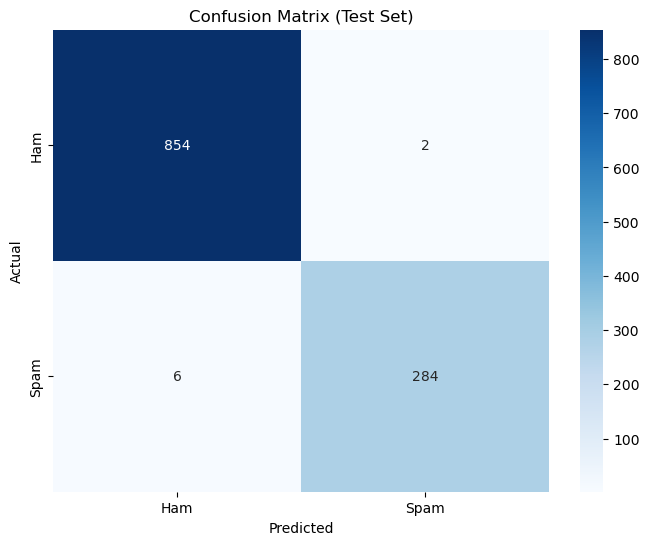

In [26]:
# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.title('Confusion Matrix (Test Set)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [27]:
# Save model
joblib.dump(best_model, 'spam_classifier_model.joblib')
joblib.dump(best_model.named_steps['tfidf'], 'tfidf_vectorizer.joblib')

['tfidf_vectorizer.joblib']

In [28]:
# Sample prediction
sample_email = "Win a free iPhone now! Click here to claim your prize!"
processed_email = preprocess_text(sample_email)
prediction = best_model.predict([processed_email])
print("\nSample Email Prediction:")
print("Spam" if prediction[0] == 1 else "Ham")


Sample Email Prediction:
Spam
